### Data wrangling

#### Load and clean data
- Import library.
- Load dataset
- Clean data: remove missing data, convert date time field

#### Split data

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go 

import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from multiscorer import MultiScorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time 


In [2]:
from chart_studio import plotly
import plotly.offline as pyoff
from __future__ import division

In [3]:
df = pd.read_csv('online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In dataset, there are 1067371 rows, but in column [CustomerID] only has 824364 non-null values and column [Description] only has 1062989 non-null values.
And the columns [InvoiceDate] has type object, not consist for columns contains value of datetime.
So, I will remove all rows contains null values, and convert type of column [InvoiceDate] to datetime.

In [5]:
df_data = df.dropna()
df_data['InvoiceDate'] = pd.to_datetime(df_data['InvoiceDate'], errors = 'coerce')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   Price        824364 non-null  float64       
 6   Customer ID  824364 non-null  float64       
 7   Country      824364 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 56.6+ MB


To build model, I split dataset to two parts: behavioral data - last purchase data of all online customers (InvoiceDate from 01/12/2009 to 30/08/2011) and first purchase date of the customers (InvoiceDate from 01/09/2011 to 30/11/2011)

In [6]:
cus_beha = df_data[(df_data['InvoiceDate']<pd.Timestamp(2011,9,1))&(df_data['InvoiceDate']>=pd.Timestamp(2009,12,1))].reset_index(drop=True)
cus_nexpur = df_data[(df_data['InvoiceDate']<pd.Timestamp(2011,12,1))&(df_data['InvoiceDate']>=pd.Timestamp(2011,9,1))].reset_index(drop=True)

Next, I create a dataframe cus_nexday that contains a set of features of each customer to build prediction model. 

Firstly, I create a dataset that contains the distinct customers in the dataframe cus_beha.
Then, I add a new label NextPurchaseDay to the dataframe cus_nexday. This new label will be the number of days between the last purchase date in cus_beha and the first first purchase date in the dataframe cus_nexpur. The NA values will be fill with 9999.

In [7]:
#get the distinct customers in the dataframe cus_beha
cusID = pd.DataFrame(cus_beha['Customer ID'].unique())
cusID.columns = ['Customer ID']

In [8]:
#create a dataframe with customer ID and first purchase date in cus_nexpur
cus_1st_purchase = cus_nexpur.groupby('Customer ID').InvoiceDate.min().reset_index()
cus_1st_purchase.columns = ['Customer ID', 'MinPurchaseDate']

#create a dataframe with customer ID and last purchase date in cus_beha
cus_last_purchase = cus_beha.groupby('Customer ID').InvoiceDate.max().reset_index()
cus_last_purchase.columns = ['Customer ID', 'MaxPurchaseDate']

#merge two dataframes
cus_nextday = pd.merge(cus_1st_purchase, cus_last_purchase, on = 'Customer ID', how = 'left')

#calculate 
cus_nextday['NextPurchaseDay'] = (cus_nextday['MinPurchaseDate'] - cus_nextday['MaxPurchaseDate']).dt.days

#merge with cusID
cusID = pd.merge(cusID, cus_nextday[['Customer ID', 'NextPurchaseDay']], on = 'Customer ID', how = 'left')

#fill NA values with 9999
cusID = cusID.fillna(9999)
cusID.head()

,Customer ID,NextPurchaseDay
0,13085.0,9999.0
1,13078.0,13.0
2,15362.0,9999.0
3,18102.0,27.0
4,12682.0,15.0


## Feature Engineering



To build model, I create an RFM score system to group the customers.
RFM stand for:
- Recency: indicating how recent a customer made a purchase.
- Frequency: how often a customer purchases.
- Monetary Value: the amount of money a customer spends when making a purchase at a point in time

After calculating the RFM score, I apply *unsupervised learning* to clustering.

### Recency


In [9]:
cus_max_purchase = cus_beha.groupby('Customer ID').InvoiceDate.max().reset_index()
cus_max_purchase.columns = ['Customer ID', 'MaxPurchaseDate']

cus_max_purchase['Recency'] = (cus_max_purchase['MaxPurchaseDate'].max() - cus_max_purchase['MaxPurchaseDate']).dt.days

cusID = pd.merge(cusID, cus_max_purchase[['Customer ID', 'Recency']], on = 'Customer ID')

In [10]:
cusID.head()

,Customer ID,NextPurchaseDay,Recency
0,13085.0,9999.0,57
1,13078.0,13.0,0
2,15362.0,9999.0,348
3,18102.0,27.0,26
4,12682.0,15.0,0


Make a figure gives a visual presentation of the recency data of the customers
- The x axis is show the recency in days
- The y axis is show the number of customers

In [11]:
plot_data = [go.Histogram(x=cusID['Recency'])]
plot_layout = go.Layout(title = 'Recency')
fig = go.Figure(data = plot_data, layout=plot_layout)
fig.show()

In [12]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by = target_field_name, ascending = ascending).reset_index()
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on = cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={'index': cluster_field_name})
    return df_final

In [13]:
for i in range(100):
    kmean = KMeans(n_clusters = 4)
    kmean.fit(cusID[['Recency']])
    cusID['RecencyCluster'] = kmean.predict(cusID[['Recency']])
    cusID = order_cluster('Recency', 'RecencyCluster', cusID, False)

In [14]:
cusID.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1333.0,447.909977,34.002023,383.0,420.0,449.0,477.0,510.0
1,1310.0,318.391603,34.692011,255.0,288.0,321.0,346.0,382.0
2,1254.0,194.428230,34.893557,132.0,165.0,193.0,227.0,254.0
3,1417.0,63.754411,40.866865,0.0,26.0,63.0,99.0,131.0


### Frequency


In [15]:
cus_frequency = df_data.groupby('Customer ID').InvoiceDate.count().reset_index()
cus_frequency.columns = ['Customer ID', 'Frequency']

cusID = pd.merge(cusID, cus_frequency, on = 'Customer ID')
cusID.head()

,Customer ID,NextPurchaseDay,RecencyCluster,Recency,Frequency
0,13085.0,9999.0,3,73,92
1,17017.0,84.0,3,73,449
2,13021.0,87.0,3,73,266
3,18203.0,9999.0,3,73,60
4,12989.0,69.0,3,73,105


Make a histogram of customers with purchase frequency less than 1000
- The x axis is show the customer frequency purchase
- The y axis is show the number of customers

In [16]:
plot_data = [go.Histogram(x=cusID.query('Frequency < 1000')['Frequency'])]
plot_layout = go.Layout(title = 'Frequency')
fig = go.Figure(data = plot_data, layout = plot_layout)
fig.show()

In [17]:
for i in range(100):
    kmean = KMeans(n_clusters = 4)
    kmean.fit(cusID[['Frequency']])
    cusID['FrequencyCluster'] = kmean.predict(cusID[['Frequency']])
    cusID = order_cluster('Frequency', 'FrequencyCluster', cusID, False)

In [18]:
cusID.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1639.0,612.260525,55.598024,519.0,559.00,612.0,668.00,697.0
1,1340.0,434.814179,46.228341,355.0,393.00,439.0,474.00,518.0
2,1298.0,258.503082,61.048109,154.0,196.25,270.0,313.75,354.0
3,1037.0,88.967213,48.481088,0.0,44.00,93.0,137.00,153.0


### Monetary Value


In [19]:
df_data['MonetaryValue'] = df_data['Quantity'] * df_data['Price']

In [20]:
cus_Mone_Value = df_data.groupby('Customer ID').MonetaryValue.sum().reset_index()

cusID = pd.merge(cusID, cus_Mone_Value, on = 'Customer ID')

Make the figure illustrates a visual representation of customers whose spend money below $10,000
- The x axis is the amount of the money is spent
- The y axis is the numers of customers

In [21]:
plot_data = [go.Histogram(x = cusID.query('MonetaryValue > 0 & MonetaryValue < 10000')['MonetaryValue'])]

plot_layout = go.Layout(title= 'Monetary Value')

fig = go.Figure(data = plot_data, layout = plot_layout)
fig.show()

In [22]:
for i in range(100):
    kmean = KMeans(n_clusters= 4)
    kmean.fit(cusID[['MonetaryValue']])
    cusID['MoneValueCluster'] = kmean.predict(cusID[['MonetaryValue']])
    cusID = order_cluster('MoneValueCluster', 'MonetaryValue', cusID, True)

In [23]:

cusID.groupby('MoneValueCluster')['MonetaryValue'].describe()

,count,mean,std,min,25%,50%,75%,max
MoneValueCluster,,,,,,,,
0,5239.0,2029.765680,3092.142184,-25111.09,344.6650,924.360,2327.0900,23090.47
1,65.0,44586.315431,22598.241628,23350.74,26960.0200,35866.630,55703.1300,113513.07
2,8.0,198033.391250,62010.602305,136391.48,142827.5300,181355.750,242746.6750,296564.69
3,2.0,560778.645000,52943.312094,523342.07,542060.3575,560778.645,579496.9325,598215.22


### Overall Score

Now, when I have Recency, Frequency and Monetary Value. I add a new column OverallScore to CusID as the value of the sum of the cluster values obtained for RFM.

In [24]:
cusID['OverallScore'] = cusID['RecencyCluster'] + cusID['FrequencyCluster'] + cusID['MoneValueCluster']
cusID

,Customer ID,NextPurchaseDay,RecencyCluster,Recency,FrequencyCluster,Frequency,MonetaryValue,MoneValueCluster,OverallScore
0,13085.0,9999.0,3,73,0,559,1459.46,0,3
1,14034.0,135.0,3,73,0,559,512.02,0,3
2,17544.0,9999.0,1,276,0,559,960.69,0,1
3,16835.0,9999.0,2,191,0,559,1471.51,0,2
4,18259.0,281.0,1,284,0,559,4318.20,0,1
...,...,...,...,...,...,...,...,...,...
5309,14911.0,2.0,2,207,3,117,270248.53,2,7
5310,14156.0,17.0,3,90,0,544,296564.69,2,5
5311,17511.0,21.0,3,90,0,626,171885.98,2,5
5312,14646.0,7.0,1,321,2,156,523342.07,3,6


In [25]:
cusID.groupby('OverallScore')[['Recency', 'Frequency', 'MonetaryValue']].mean()

,Recency,Frequency,MonetaryValue
OverallScore,,,
0,450.094891,613.576642,1921.599273
1,377.967168,533.056088,2421.721754
2,314.433908,444.829502,2147.241804
3,228.415313,384.374323,2852.817475
4,177.693048,285.433155,3279.269865
5,124.947205,185.133540,4318.375654
6,65.959514,97.060729,5214.934543
7,57.333333,68.888889,68018.655556


The scoring above clearly shows that customers with an overall score of  are the positively outstanding customers who bring much value to te company whereas those assigned a score of 3 are supposedly inreliable and merely wandering.

So, I group the customers into the segments based on their overall score as follows:
- 0 to 2: low value
- 3 to 5: mid value
- 6 to 8 : high value

In [26]:
cusID['Segment'] = 'Low Value'
cusID.loc[cusID['OverallScore']>2, 'Segment'] = 'Mid Value'
cusID.loc[cusID['OverallScore']>5, 'Segment'] = 'High Value'
cusID

,Customer ID,NextPurchaseDay,RecencyCluster,Recency,FrequencyCluster,Frequency,MonetaryValue,MoneValueCluster,OverallScore,Segment
0,13085.0,9999.0,3,73,0,559,1459.46,0,3,Mid Value
1,14034.0,135.0,3,73,0,559,512.02,0,3,Mid Value
2,17544.0,9999.0,1,276,0,559,960.69,0,1,Low Value
3,16835.0,9999.0,2,191,0,559,1471.51,0,2,Low Value
4,18259.0,281.0,1,284,0,559,4318.20,0,1,Low Value
...,...,...,...,...,...,...,...,...,...,...
5309,14911.0,2.0,2,207,3,117,270248.53,2,7,High Value
5310,14156.0,17.0,3,90,0,544,296564.69,2,5,Mid Value
5311,17511.0,21.0,3,90,0,626,171885.98,2,5,Mid Value
5312,14646.0,7.0,1,321,2,156,523342.07,3,6,High Value


In [27]:
cusID.groupby('Segment')[['Customer ID']].count()

,Customer ID
Segment,
High Value,256
Low Value,2186
Mid Value,2872


Then, I create a copy of cusID and apply method get_dummies to convert all categorical column Segment to indicator variables.

In [28]:
cus_class = cusID.copy()
cus_class = pd.get_dummies(cus_class)

In [29]:
cus_class.head()

,Customer ID,NextPurchaseDay,RecencyCluster,Recency,FrequencyCluster,Frequency,MonetaryValue,MoneValueCluster,OverallScore,Segment_High Value,Segment_Low Value,Segment_Mid Value
0,13085.0,9999.0,3,73,0,559,1459.46,0,3,False,False,True
1,14034.0,135.0,3,73,0,559,512.02,0,3,False,False,True
2,17544.0,9999.0,1,276,0,559,960.69,0,1,False,True,False
3,16835.0,9999.0,2,191,0,559,1471.51,0,2,False,True,False
4,18259.0,281.0,1,284,0,559,4318.20,0,1,False,True,False


My goal is predict whether a customer will make a purchase in the next quarter. So, I create a new column NextPurchaseDayRange with values as either 1 or 0 defined:
- 1 if it indicates that the customer will buy something in the next quarter (90 days) from his/her last purchase.
- 0 if it indicates that the customer will buy something in more than 90 days from his/her last purchase.

In [30]:
cus_class['NextPurchaseDayRange'] = 1
cus_class.loc[cus_class.NextPurchaseDay > 90.0, 'NextPurchaseDayRange'] = 0

In [31]:
cus_class.groupby('NextPurchaseDayRange')[['Customer ID']].count()

,Customer ID
NextPurchaseDayRange,
0,4308
1,1006


Then, I conclude this section by computing the correlation between the features and label.

In [32]:
corr_matrix = cus_class[cus_class.columns].corr()
corr_df = pd.DataFrame(corr_matrix.min())

corr_df.columns = ['MinCorr']
corr_df['MAxCorr'] = corr_matrix[corr_matrix<1].max()

corr_df

,MinCorr,MAxCorr
Customer ID,-0.029737,0.021631
NextPurchaseDay,-0.569494,0.023684
RecencyCluster,-0.969892,0.709448
Recency,-0.969892,0.602083
FrequencyCluster,-0.963902,0.695815
Frequency,-0.963902,0.528580
MonetaryValue,-0.164560,0.799774
MoneValueCluster,-0.119233,0.799774
OverallScore,-0.825930,0.709448
Segment_High Value,-0.316710,0.448997


<Axes: >

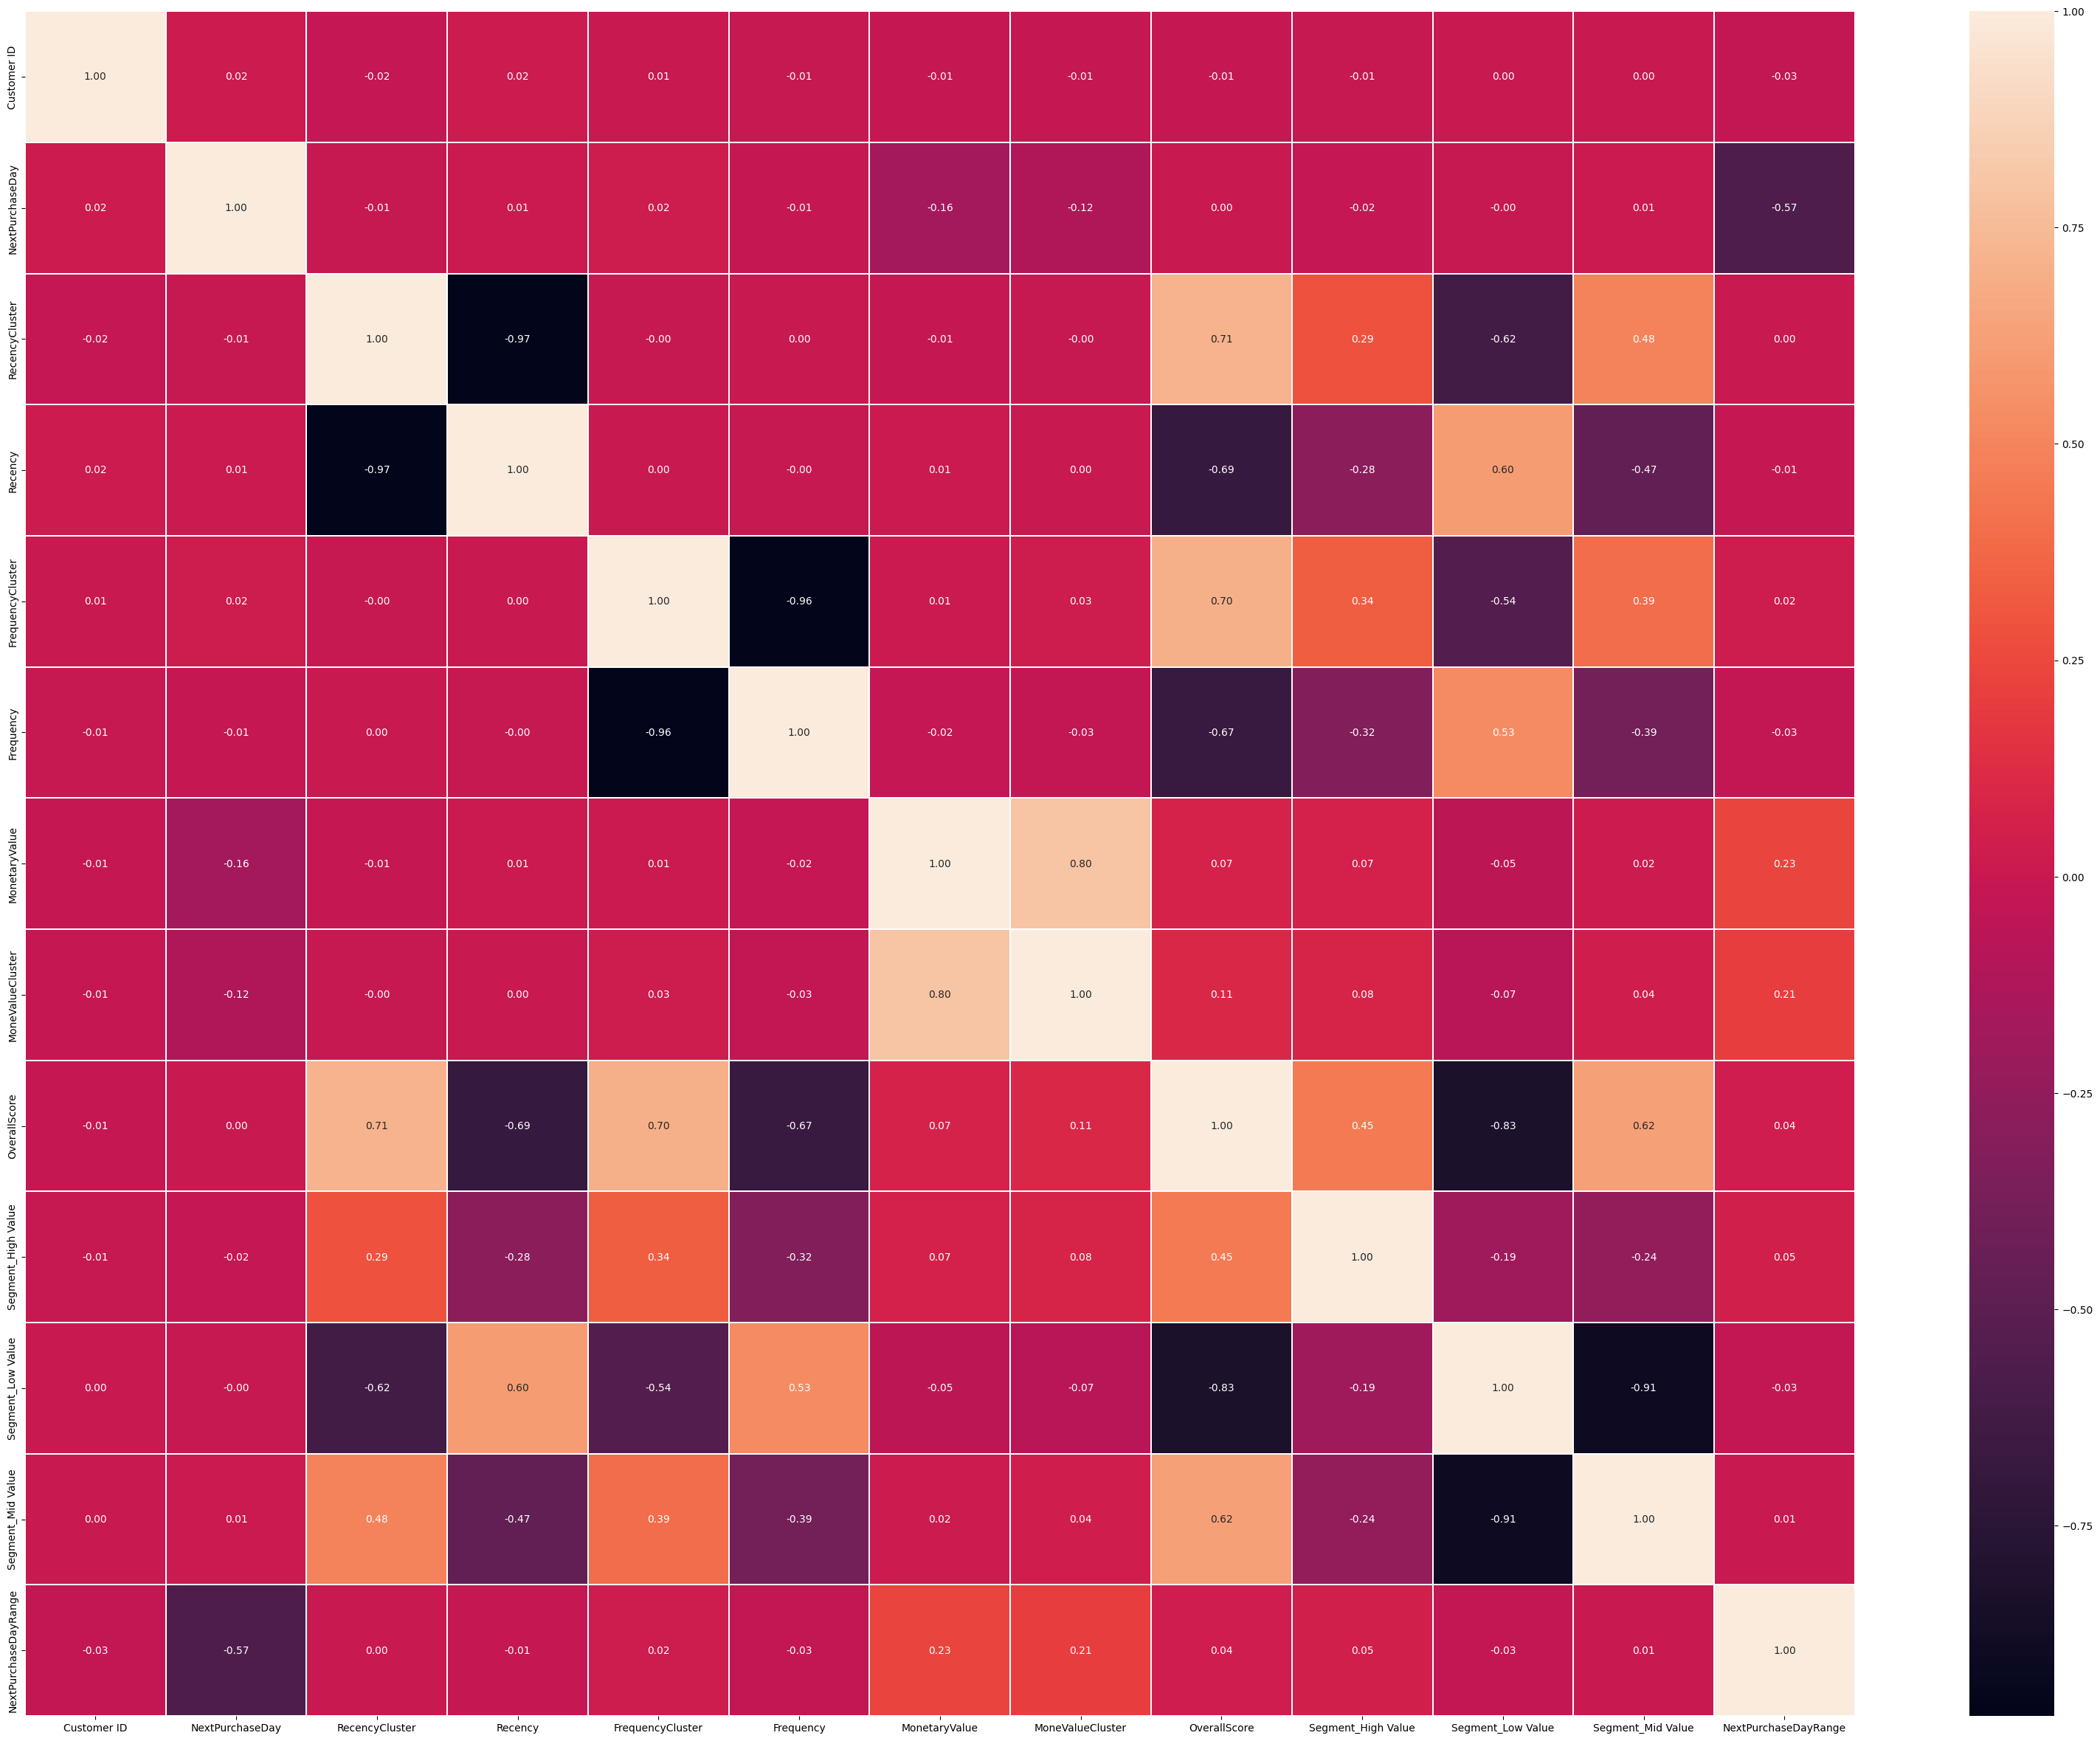

In [33]:
plt.figure(figsize=(40,30))
sns.heatmap(corr_matrix, annot = True, linewidths = 0.2, fmt=".2f")

## Build Machine Learning Models


I separates the dataframe cus_class into X features and the target variable y. Afterwards, I split X and y to get the training and test datasets.

In [34]:
cus_class = cus_class.drop('NextPurchaseDay', axis=1)
X, y = cus_class.drop('NextPurchaseDayRange', axis=1), cus_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

Let's try some models and choose the best one.

In [35]:

models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric = 'mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [36]:
scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })

model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }

for model_name, model in models: 
    
    model_scores_dict['model_name'].append(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    for metric_name in cv_result.keys():
        average_score = np.average(cv_result[metric_name])
        model_scores_dict[metric_name].append(average_score)

    model_scores_dict['time'].append((time.time() - start))
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

,accuracy,f1_score,recall,precision,time
model_name,,,,,
LogisticRegression,0.848038,0.664868,0.633913,0.795387,0.177124
RandomForestClassifier,0.847017,0.671668,0.644374,0.787178,1.384419
SVC,0.846626,0.664765,0.637560,0.791929,0.451602
GaussianNB,0.845685,0.650326,0.622000,0.799368,0.031939
xgb.XGBClassifier,0.840392,0.680864,0.661203,0.767727,1.519737
KNeighborsClassifier,0.839535,0.682066,0.662313,0.761899,0.443356
DecisionTreeClassifier,0.836887,0.666346,0.645201,0.767521,0.088542


From this result, I see that XGBClassifier is the best performing one (~87% accuracy). So, Let's improve the model XGB Classifier.

XGB Classifier has many parameters. So, I select max_depth and min_child_weight to impove it futher. 

In [37]:
parameter = {
    'max_depth': range(3,10,2),
    'min_child-weight': range(1,5,2)
}

p_grid_search = GridSearchCV(estimator= xgb.XGBClassifier(eval_metric = 'mlogloss'), 
                             param_grid= parameter,
                             scoring='accuracy',
                             n_jobs=-1,
                             cv=2)

p_grid_search.fit(X_train, y_train)


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child-weight': range(1, 5, 2)},
             scoring='accuracy')

In [38]:
refined_xgb = xgb.XGBClassifier(eval_metric = 'logloss',
                                max_depth = list(p_grid_search.best_params_.values())[0],
                                min_child_weight = list(p_grid_search.best_params_.values())[-1]).fit(X_train, y_train)

In [39]:
print('Accuracy of refined XGB classifier on training set: {:.5f}'.format(refined_xgb.score(X_train, y_train)))
print('Accuracy of refined XGB classifier on test set: {:.5f}'.format(refined_xgb.score(X_test[X_train.columns], y_test)))

Accuracy of refined XGB classifier on training set: 0.92002
Accuracy of refined XGB classifier on test set: 0.88147


To choose the best model, let''s compare with the model Logistic regression has the best recall, precision and f1_score.

Fit the models into test set

In [40]:
refined_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [41]:
y_pred_xgb = refined_xgb.predict(X_test)

In [42]:
y_pred_log = LogisticRegression().fit(X_train, y_train).predict(X_test)

Now, compute the confusion matrices and visualization them.


In [43]:
def get_confusion_matric(y_test, y_pred):
    data = {'y_actual': y_test, 'y_predicted': y_pred}
    df = pd.DataFrame(data, columns = ['y_actual', 'y_predicted'])
    conf_matrix = pd.crosstab(df['y_actual'], df['y_predicted'],
                             rownames= ['Actual'], colnames = ['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")
    plt.show()

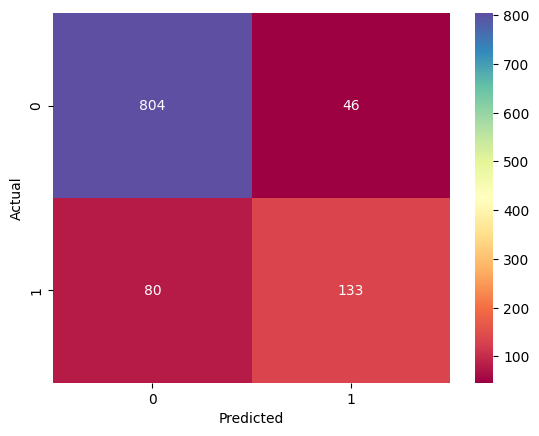

In [44]:
get_confusion_matric(np.array(y_test), y_pred_xgb)

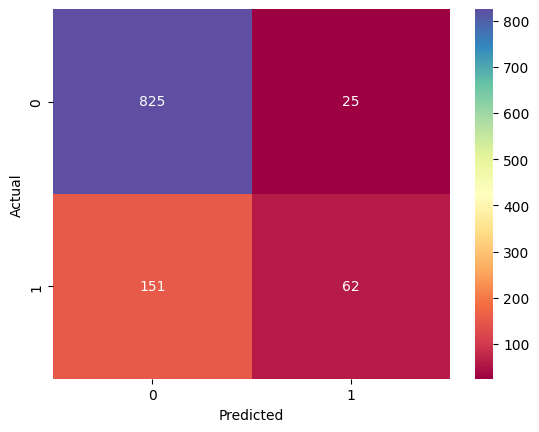

In [45]:
get_confusion_matric(np.array(y_test), y_pred_log)

In [46]:
xgb_log_reg_dict = {"model_name" : ["xgb.XGBClassifier", "LogisticRegression"], 
                        "accuracy"   : [accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_log)], 
                        "f1_score"   : [f1_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_log)], 
                        "recall"     : [recall_score(y_test, y_pred_xgb), recall_score(y_test, y_pred_log)], 
                        "precision"  : [precision_score(y_test, y_pred_xgb), precision_score(y_test, y_pred_log)]
                       }

xgb_log_reg_df = pd.DataFrame(xgb_log_reg_dict).set_index("model_name")

xgb_log_reg_df.sort_values(by=["accuracy", "f1_score", "recall", "precision"], ascending=False)


,accuracy,f1_score,recall,precision
model_name,,,,
xgb.XGBClassifier,0.881468,0.678571,0.624413,0.743017
LogisticRegression,0.834431,0.413333,0.291080,0.712644


See the result with XGBoost model

In [48]:
X_test['y_actual_value'] = y_test
X_test['y_pred'] = y_pred_xgb
X_test

,Customer ID,RecencyCluster,Recency,FrequencyCluster,Frequency,MonetaryValue,MoneValueCluster,OverallScore,Segment_High Value,Segment_Low Value,Segment_Mid Value,y_actual_value,y_pred
3000,15586.0,1,317,2,246,1128.66,0,3,False,False,True,0,0
2068,13401.0,3,9,3,141,-1834.14,0,6,True,False,False,0,0
962,16002.0,3,61,0,624,169.21,0,3,False,False,True,0,0
1630,16670.0,3,6,0,682,7786.66,0,3,False,False,True,1,1
3589,12530.0,0,433,1,459,3689.86,0,1,False,True,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,14636.0,0,445,0,696,609.85,0,0,False,True,False,0,0
3330,17462.0,0,409,0,696,662.94,0,0,False,True,False,0,0
2528,17254.0,3,99,1,484,470.73,0,4,False,False,True,0,0
4453,18179.0,3,60,0,553,2547.55,0,3,False,False,True,0,0


In [49]:
X_test

,Customer ID,RecencyCluster,Recency,FrequencyCluster,Frequency,MonetaryValue,MoneValueCluster,OverallScore,Segment_High Value,Segment_Low Value,Segment_Mid Value,y_actual_value,y_pred
3000,15586.0,1,317,2,246,1128.66,0,3,False,False,True,0,0
2068,13401.0,3,9,3,141,-1834.14,0,6,True,False,False,0,0
962,16002.0,3,61,0,624,169.21,0,3,False,False,True,0,0
1630,16670.0,3,6,0,682,7786.66,0,3,False,False,True,1,1
3589,12530.0,0,433,1,459,3689.86,0,1,False,True,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,14636.0,0,445,0,696,609.85,0,0,False,True,False,0,0
3330,17462.0,0,409,0,696,662.94,0,0,False,True,False,0,0
2528,17254.0,3,99,1,484,470.73,0,4,False,False,True,0,0
4453,18179.0,3,60,0,553,2547.55,0,3,False,False,True,0,0


In [50]:
compare_df = X_test.assign(
    compare_actual_value_with_pred = lambda x: x['y_actual_value'] == x['y_pred']
)

In [51]:
print('Wrong prediction in test set', compare_df[compare_df['compare_actual_value_with_pred'] == False].shape[0])
print('True prediction in test set', compare_df[compare_df['compare_actual_value_with_pred'] == True].shape[0])

Wrong prediction in test set 126
True prediction in test set 937


In [52]:
print('True prediction in segment high value', compare_df[(compare_df['compare_actual_value_with_pred'] == True)&(compare_df['Segment_High Value'] == True)].shape[0],'/',compare_df[compare_df['Segment_High Value'] == True].shape[0])
print('True prediction in segment mid value',compare_df[(compare_df['compare_actual_value_with_pred'] == True) & (compare_df['Segment_Mid Value'] == True)].shape[0],'/', compare_df[compare_df['Segment_Mid Value'] == True].shape[0])
print('True prediction in segment low Value',compare_df[(compare_df['compare_actual_value_with_pred'] == True)& (compare_df['Segment_Low Value'] == True)].shape[0],'/', compare_df[compare_df['Segment_Low Value'] == True].shape[0])

True prediction in segment high value 42 / 45
True prediction in segment mid value 486 / 548
True prediction in segment low Value 409 / 470
